In [160]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import ast

from scipy.stats import spearmanr

import seaborn as sns
from matplotlib import pyplot as plt

In [99]:
def load_data(data_file, drop_cols=['Preamble'], convert_prob=True):
    data = pd.read_csv(data_file, sep='|')
    data = data.drop(drop_cols, axis=1)

    try:
        data['stimulus_prob'] = [[t for t in m] for m in data['stimulus_prob'].apply(ast.literal_eval)]
    except ValueError as e:
        for m in data['stimulus_prob']:
            print(m)
        print(data['stimulus_prob'])
        return None
    
    if convert_prob:
        data['stimulus_prob'] = [[2 ** t for t in m] for m in data['stimulus_prob']]

    return pd.DataFrame(data)

In [37]:
def split_confusion_matrix(df):
    test_pos = df.loc[(df['Dependent_Variable'] == 'present')]
    test_neg = df.loc[(df['Dependent_Variable'] == 'absent')]

    true_neg  = test_neg.loc[(test_neg['True_Category'] ==  'absent')]
    false_pos = test_pos.loc[(test_pos['True_Category'] ==  'absent')]
    false_neg = test_neg.loc[(test_neg['True_Category'] == 'present')]
    true_pos  = test_pos.loc[(test_pos['True_Category'] == 'present')]

    # Decided to return in the same order expected from sklearn confusion_matrix function
    return true_neg, false_pos, false_neg, true_pos

In [186]:
def confusion_scatter(df, fan_type = 'both', aggregate=False):
    if fan_type == 'both':
        fan = lambda a, b : (a*a + b*b)**(1/2)
    elif fan_type == 'first':
        fan = lambda a, b : a
    elif fan_type == 'second':
        fan = lambda a, b : b

    def fill_subplot(ax, df_part : pd.DataFrame):
        x = []
        y = []

        for _, row in df_part.iterrows():
            fan_per = row['Fan_Person']
            fan_pla = row['Fan_Place']
            probs = row['stimulus_prob']

            if aggregate:
                x.append(fan(fan_per, fan_pla))
                y.append(np.mean(probs))
            else:
                x += [fan(fan_per, fan_pla)] * len(probs)
                y += probs
        
        x, y = np.asarray(x), np.asarray(y)

        m, b = np.polyfit(x, y, 1)
        r, p = spearmanr(x, y, axis=0)

        ax.scatter(x,y, c=(0,0,0,max(0.04,1/len(x))))
        ax.plot(x, m*x + b, c='red')
        ax.text(0.01,0.01, f'r={r:.3f}, p={p:.3f}', c='red', transform=ax.transAxes)

    tn, fp, fn, tp = split_confusion_matrix(df)

    fig, axes = plt.subplots(nrows = 2, ncols = 2)

    fill_subplot(axes[0][0], tp)
    fill_subplot(axes[0][1], fn)
    fill_subplot(axes[1][0], fp)
    fill_subplot(axes[1][1], tn)

    plt.show()

In [181]:
rand = load_data('../data/Random/results_LLaMa3-8b.csv', convert_prob=False)
and_true = load_data('../data/And_True/results_LLaMa3-8b.csv', convert_prob=False)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_21160\42961656.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x,y, c=(0,0,0,max(0.04,1/len(x))))


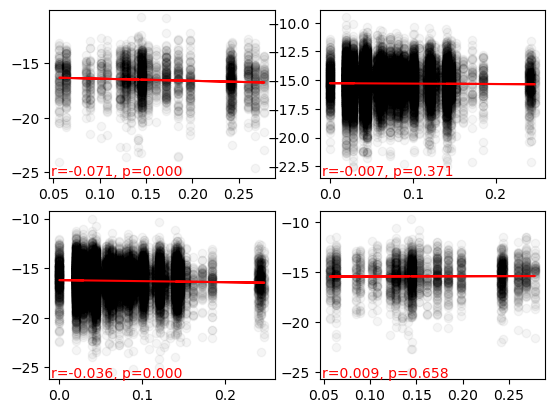

In [187]:
confusion_scatter(rand, fan_type='both', aggregate=False)


C:\Users\Kyle\AppData\Local\Temp\ipykernel_21160\3375397960.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x,y, c=(0,0,0,max(0.1,1/len(x))))


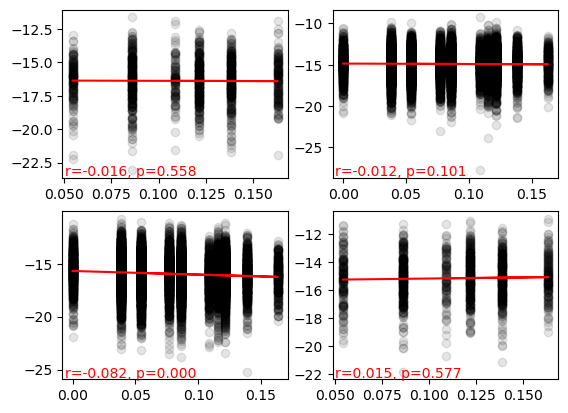

In [183]:
confusion_scatter(and_true, fan_type='both', aggregate=False)